In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from joblib import dump

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, QuantileTransformer
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture


In [16]:
RANDOM_STATE = 42

TRAIN_PATH = "train_data.csv"
TEST_PATH  = "test_data.csv"   # not used for clustering, but good to sanity-check

ARTIFACT_DIR = Path("artifacts")
ARTIFACT_DIR.mkdir(exist_ok=True)


In [17]:
# ---- Load train ----
train_df = pd.read_csv(TRAIN_PATH)
train_df.columns = [c.strip() for c in train_df.columns]

# Identify target and index columns robustly
target_candidates = [c for c in train_df.columns if "bankrupt" in c.lower()]
if not target_candidates:
    raise ValueError("Couldn't find a target column containing 'bankrupt'.")
TARGET_COL = target_candidates[0]

index_candidates = [c for c in train_df.columns if c.lower() in ("index", "id", "company_id")]
INDEX_COL = index_candidates[0] if index_candidates else None

print("TARGET_COL:", TARGET_COL)
print("INDEX_COL:", INDEX_COL)
print("Train shape:", train_df.shape)
print("Target distribution:\n", train_df[TARGET_COL].value_counts())

# ---- Load test (optional sanity check) ----
if Path(TEST_PATH).exists():
    test_df = pd.read_csv(TEST_PATH)
    test_df.columns = [c.strip() for c in test_df.columns]
    print("\nLoaded TEST_PATH:", TEST_PATH, "shape:", test_df.shape)
else:
    print("\nTEST_PATH not found – that's OK for clustering, "
          "but you will need it later for generalization.")


TARGET_COL: Bankrupt?
INDEX_COL: Index
Train shape: (5807, 97)
Target distribution:
 Bankrupt?
0    5609
1     198
Name: count, dtype: int64

TEST_PATH not found – that's OK for clustering, but you will need it later for generalization.


In [18]:
class ColumnNameStripper(BaseEstimator, TransformerMixin):
    """Ensures any incoming DataFrame has stripped column names."""
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X = X.copy()
        X.columns = [str(c).strip() for c in X.columns]
        return X


class ColumnDropper(BaseEstimator, TransformerMixin):
    """Drops specified columns if they exist."""
    def __init__(self, drop_cols=None):
        self.drop_cols = drop_cols or []
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X = X.copy()
        cols = [c for c in self.drop_cols if c in X.columns]
        return X.drop(columns=cols)


class HighCorrelationFilter(BaseEstimator, TransformerMixin):
    """
    Drops features with absolute correlation above threshold.
    Keeps the first feature in each correlated group.
    """
    def __init__(self, threshold=0.98):
        self.threshold = float(threshold)

    def fit(self, X, y=None):
        Xdf = pd.DataFrame(X).copy()
        corr = Xdf.corr(numeric_only=True).abs()
        upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
        to_drop = [col for col in upper.columns if any(upper[col] > self.threshold)]
        self.keep_cols_ = [c for c in Xdf.columns if c not in to_drop]
        self.dropped_cols_ = to_drop
        return self

    def transform(self, X):
        Xdf = pd.DataFrame(X).copy()
        return Xdf[self.keep_cols_]


class SkewAndTopcodeHandler(BaseEstimator, TransformerMixin):
    """
    Handle very large-scale nonnegative columns by clipping and log1p transforming.
    NOTE: Topcode INDICATOR features have been REMOVED (only clip + log1p).
    """
    def __init__(self, huge_max_threshold=1e6, sentinel_fraction=0.95):
        self.huge_max_threshold = float(huge_max_threshold)
        self.sentinel_fraction = float(sentinel_fraction)

    def fit(self, X, y=None):
        Xdf = pd.DataFrame(X).copy()

        self.cols_in_ = list(Xdf.columns)
        self.huge_cols_ = []
        self.clip_ = {}

        for c in self.cols_in_:
            s = Xdf[c]
            mx, mn = float(s.max()), float(s.min())
            if mx > self.huge_max_threshold and mn >= 0:
                self.huge_cols_.append(c)
                self.clip_[c] = self.sentinel_fraction * mx

        return self

    def transform(self, X):
        Xdf = pd.DataFrame(X, columns=self.cols_in_).copy()

        for c in self.huge_cols_:
            clip_val = self.clip_[c]
            Xdf[c] = np.log1p(np.minimum(Xdf[c].values, clip_val))

        return Xdf


class ConstantColumnDropper(BaseEstimator, TransformerMixin):
    """Drops columns with <=1 unique value (constant)."""
    def fit(self, X, y=None):
        Xdf = pd.DataFrame(X).copy()
        nunique = Xdf.nunique(dropna=False)
        self.drop_cols_ = nunique[nunique <= 1].index.tolist()
        self.keep_cols_ = [c for c in Xdf.columns if c not in self.drop_cols_]
        return self

    def transform(self, X):
        Xdf = pd.DataFrame(X).copy()
        return Xdf[self.keep_cols_]


In [19]:
# Build raw X / y for training
drop_cols = [TARGET_COL]
if INDEX_COL is not None:
    drop_cols.append(INDEX_COL)

X_train_raw = train_df.drop(columns=drop_cols).copy()
y_train = train_df[TARGET_COL].astype(int).values

# Detect Liability-Assets flag column (if present)
LIAB_ASSET_FLAG = None
for c in X_train_raw.columns:
    if "liability-assets flag" in c.lower():
        LIAB_ASSET_FLAG = c
        break

# Core preprocessing for later supervised models (cluster-id classifier, subgroup models)
core_preprocess = Pipeline(steps=[
    ("strip_names", ColumnNameStripper()),
    ("drop_constant", ConstantColumnDropper()),
    ("corr_filter", HighCorrelationFilter(threshold=0.98)),
    ("skew_topcode", SkewAndTopcodeHandler(huge_max_threshold=1e6, sentinel_fraction=0.95)),
    ("robust_scale", RobustScaler(with_centering=True, with_scaling=True)),
    ("quantile_gauss", QuantileTransformer(
        output_distribution="normal",
        n_quantiles=2000,
        random_state=RANDOM_STATE
    )),
])

# Preprocessing specifically for clustering (drop Liability-Assets flag for clustering)
cluster_preprocess = Pipeline(steps=[
    ("strip_names", ColumnNameStripper()),
    ("drop_cols", ColumnDropper(drop_cols=[LIAB_ASSET_FLAG] if LIAB_ASSET_FLAG else [])),
    ("drop_constant", ConstantColumnDropper()),
    ("corr_filter", HighCorrelationFilter(threshold=0.98)),
    ("skew_topcode", SkewAndTopcodeHandler(huge_max_threshold=1e6, sentinel_fraction=0.95)),
    ("robust_scale", RobustScaler(with_centering=True, with_scaling=True)),
    ("quantile_gauss", QuantileTransformer(
        output_distribution="normal",
        n_quantiles=2000,
        random_state=RANDOM_STATE
    )),
    ("pca", PCA(n_components=50, random_state=RANDOM_STATE)),
])

# Fit preprocessors on full training data
core_preprocess.fit(X_train_raw)
cluster_preprocess.fit(X_train_raw)

bundle = {
    "TARGET_COL": TARGET_COL,
    "INDEX_COL": INDEX_COL,
    "LIAB_ASSET_FLAG": LIAB_ASSET_FLAG,
    "core_preprocess": core_preprocess,
    "cluster_preprocess": cluster_preprocess,
}

dump(bundle, ARTIFACT_DIR / "preprocess_bundle.joblib")

print("Saved:", ARTIFACT_DIR / "preprocess_bundle.joblib")
print("Dropped constant cols:", core_preprocess.named_steps["drop_constant"].drop_cols_)
print("Dropped by corr filter (count):", len(core_preprocess.named_steps["corr_filter"].dropped_cols_))


Saved: artifacts\preprocess_bundle.joblib
Dropped constant cols: ['Net Income Flag']
Dropped by corr filter (count): 12


In [20]:
# Transform data for clustering
X_train_cluster = cluster_preprocess.transform(X_train_raw)

BEST_K = 6  # fixed by your experimentation

gmm = GaussianMixture(
    n_components=BEST_K,
    covariance_type="diag",
    random_state=RANDOM_STATE,
    reg_covar=1e-6,
    max_iter=500,
    n_init=3
)
gmm.fit(X_train_cluster)

labels = gmm.predict(X_train_cluster)
counts = np.bincount(labels, minlength=BEST_K)
pos_counts = np.array([y_train[labels == i].sum() for i in range(BEST_K)], dtype=int)
pos_rates = pos_counts / counts
bic = gmm.bic(X_train_cluster)

print("GMM trained with K =", BEST_K)
print("BIC:", bic)

# Save clustering solution
dump(
    {"BEST_K": BEST_K, "gmm": gmm},
    ARTIFACT_DIR / "clustering_solution.joblib"
)
print("Saved:", ARTIFACT_DIR / "clustering_solution.joblib")

# Attach cluster IDs to train_df
train_df = train_df.copy()
train_df["cluster_id"] = labels
train_df.head()


GMM trained with K = 6
BIC: 693638.1473683227
Saved: artifacts\clustering_solution.joblib


,Index,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,...,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability,cluster_id
0,0,0,0.450397,0.504034,0.506986,0.594640,0.594640,0.998906,0.797293,0.809239,...,0.004919,0.623634,0.594641,0.838869,0.279036,0.026788,0.565144,1,0.032464,0
1,1,0,0.530005,0.572885,0.574763,0.605695,0.605558,0.999058,0.797512,0.809399,...,0.005968,0.624171,0.605690,0.841869,0.279040,0.026801,0.565205,1,0.032442,1
2,2,0,0.571150,0.620148,0.624177,0.612275,0.612282,0.999163,0.797654,0.809533,...,0.006022,0.625306,0.612271,0.843294,0.278927,0.026816,0.565276,1,0.033034,1
3,3,0,0.483401,0.556694,0.536164,0.602445,0.602445,0.999035,0.797458,0.809380,...,0.002177,0.621610,0.602444,0.841891,0.293391,0.027063,0.566190,1,0.015406,3
4,4,0,0.510359,0.537287,0.552546,0.600023,0.600023,0.999009,0.797406,0.809313,...,0.001124,0.623993,0.600019,0.840313,0.279878,0.026880,0.565549,1,0.028858,0


   cluster_id  n_companies  n_bankrupt  bankrupt_rate
0           0         2264          71       0.031360
1           1         1094           2       0.001828
2           2          191          31       0.162304
3           3         1214          75       0.061779
4           4          799           0       0.000000
5           5          245          19       0.077551


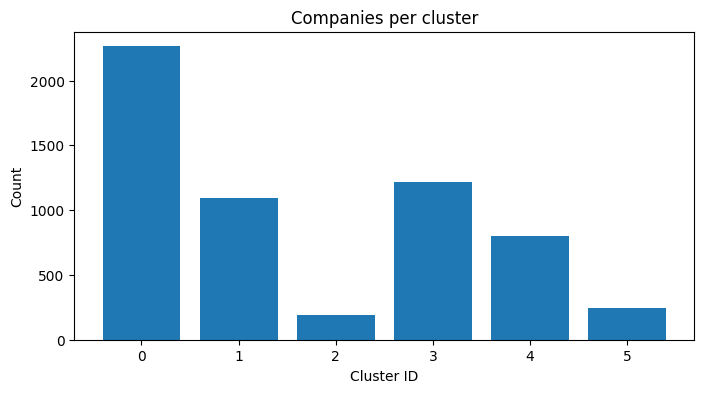

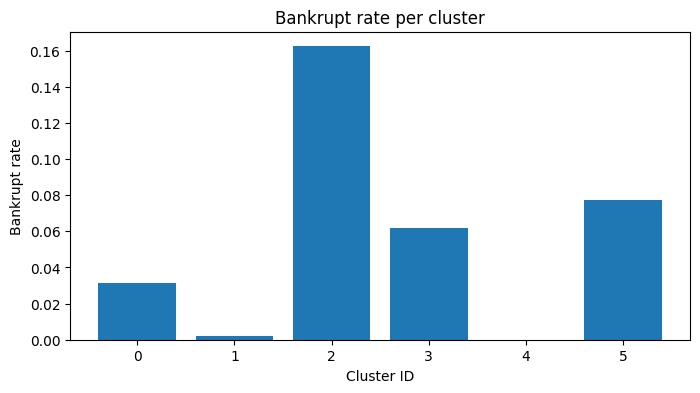

[WindowsPath('artifacts/cluster_0_train.csv'),
 WindowsPath('artifacts/cluster_1_train.csv'),
 WindowsPath('artifacts/cluster_2_train.csv'),
 WindowsPath('artifacts/cluster_3_train.csv'),
 WindowsPath('artifacts/cluster_4_train.csv'),
 WindowsPath('artifacts/cluster_5_train.csv')]

In [21]:
# Summary statistics per cluster
cluster_table = []
for cid in range(BEST_K):
    mask = labels == cid
    n = int(mask.sum())
    b = int(y_train[mask].sum())
    cluster_table.append({
        "cluster_id": cid,
        "n_companies": n,
        "n_bankrupt": b,
        "bankrupt_rate": b / n if n else 0.0
    })

cluster_stats = pd.DataFrame(cluster_table).sort_values("cluster_id")
print(cluster_stats)

# Simple visualizations (optional but helpful)
fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(cluster_stats["cluster_id"], cluster_stats["n_companies"])
ax.set_title("Companies per cluster")
ax.set_xlabel("Cluster ID")
ax.set_ylabel("Count")
plt.show()

fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(cluster_stats["cluster_id"], cluster_stats["bankrupt_rate"])
ax.set_title("Bankrupt rate per cluster")
ax.set_xlabel("Cluster ID")
ax.set_ylabel("Bankrupt rate")
plt.show()

# ---- Save one CSV per cluster for teammates ----
cluster_csv_paths = []
for cid in range(BEST_K):
    cluster_df = train_df[train_df["cluster_id"] == cid].copy()
    out_path = ARTIFACT_DIR / f"cluster_{cid}_train.csv"
    cluster_df.to_csv(out_path, index=False)
    cluster_csv_paths.append(out_path)

cluster_csv_paths
